**Module:** read_and_map_viirs.ipynb

**Disclaimer**: The code is for demonstration purposes only. Users are responsible to check for accuracy and revise to fit their objective.

**Organization**: NASA ARSET

**Author**: Justin Roberts-Pierel and Pawan Gupta, 2015.

**Modified to work with netCDF** : Vikalp Mishra, 2019 

**Modified to work with VIIRS DB data**: Aavash Thapa, 2020

**Modified**: Pawan Gupta, September 28 2021 to work with VIIRS DT data

**Purpose**: To extract variables from a VIIRS netCDF4 file and create and save a map of the data

In [1]:
#Mount drive to save files there
#clone the repository to access files from there
#pull the latest
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
! git clone https://github.com/pawanpgupta/DTAerosols.git
! git -C DTAerosols/ pull

Mounted at /content/drive
Cloning into 'DTAerosols'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 18 (delta 4), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (18/18), done.
Already up to date.


In [2]:
!pip install netCDF4

!grep '^deb ' /etc/apt/sources.list | \
  sed 's/^deb /deb-src /g' | \
  tee /etc/apt/sources.list.d/deb-src.list
!apt-get update

# !apt-get -qq build-dep python3-cartopy
# !apt-get -qq remove python-shapely python3-shapely

# !pip install --no-binary shapely shapely --force
# !pip install --no-binary cartopy cartopy==0.17.0
!pip install imgaug==0.2.5

!pip uninstall -y shapely;
!pip3 install --upgrade pyshp
!pip install shapely --no-binary shapely;
!pip install cartopy --upgrade

deb-src http://archive.ubuntu.com/ubuntu/ bionic main restricted
deb-src http://archive.ubuntu.com/ubuntu/ bionic-updates main restricted
deb-src http://archive.ubuntu.com/ubuntu/ bionic universe
deb-src http://archive.ubuntu.com/ubuntu/ bionic-updates universe
deb-src http://archive.ubuntu.com/ubuntu/ bionic multiverse
deb-src http://archive.ubuntu.com/ubuntu/ bionic-updates multiverse
deb-src http://archive.ubuntu.com/ubuntu/ bionic-backports main restricted universe multiverse
deb-src http://security.ubuntu.com/ubuntu/ bionic-security main restricted
deb-src http://security.ubuntu.com/ubuntu/ bionic-security universe
deb-src http://security.ubuntu.com/ubuntu/ bionic-security multiverse
deb-src https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/mach

In [3]:
import numpy as np
import pandas as pd
import sys
from netCDF4 import Dataset
import matplotlib.pyplot as plt
#Colab requires specific installation of cartopy
#!apt-get -qq install python-cartopy python3-cartopy;

#!pip install python3-cartopy
#!pip uninstall -y shapely;    # cartopy and shapely aren't friends (early 2020)
#!pip install shapely --no-binary shapely;


import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh
from textwrap import wrap

In [4]:
# Change the path to the appropriate cartopy_feature_download.py on google drive
!python "drive/MyDrive/Colab Notebooks/cartopy_feature_download.py" physical

/usr/local/lib/python3.7/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
Feature physical, coastline, 110m length: 134
/usr/local/lib/python3.7/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
Feature physical, coastline, 50m length: 1428
/usr/local/lib/python3.7/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
Feature physical, coastline, 10m length: 4133
/usr/local/lib/python3.7/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land


Would you like to process
AERDT_L2_VIIRS_SNPP.A2021269.2042.011.2021270073049.nc

(Y/N)y
Pick the number with the corresponding sds variable of your choice: 
              1) Image_Optical_Depth_Land_And_Ocean
              2) Optical_Depth_Land_And_Ocean
              3) Land_Ocean_Quality_Flag
              4) Land_Sea_Flag
              5) Angstrom_Exponent_1_Ocean 1
The average of this data is:  0.186 
The standard deviation is:  0.321 
The median is:  0.091
The range of latitude in this file is:  19.32293128967285  to  44.45458984375 degrees 
The range of longitude in this file is:  -136.28750610351562  to  -97.96835327148438  degrees

Would you like to create a map of this data? Please enter Y or N 
y


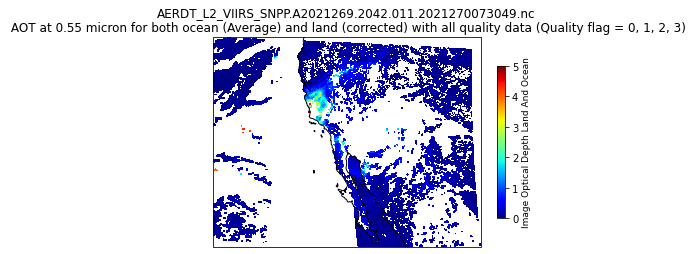


Would you like to save this map? Please enter Y or N 
y


In [5]:
#!/usr/bin/python
try:
    fileList = open('DTAerosols/fileList.txt', 'r')
except:
    print('Did not find a text file containing file names (perhaps name does not match)')
    sys.exit()

#loops through all files listed in the text file
for FILE_NAME in fileList:
    FILE_NAME=FILE_NAME.strip()
    #change 'raw_input' to 'input' if an error is shown about the input
    user_input=input('\nWould you like to process\n' + FILE_NAME + '\n\n(Y/N)')
    if(user_input == 'N' or user_input == 'n'):
        print('Skipping...')
        continue
    else:
        file = Dataset('DTAerosols/'+ FILE_NAME, 'r')
# read the data
        ds=file
        #grp='PRODUCT'     
        grp='/geolocation_data/'
        geods = ds[grp]   
        lat= geods.variables['latitude'][:][:]
        lon= geods.variables['longitude'][:][:]
        if 'AERDT' in FILE_NAME:
            
            #The user has a choice of 5 sds variable and has to input a number to choose.
            #The loop keeps repeating until the user inputs a value between 1-5 inclusive.
            while  True:
              choice = input("""Pick the number with the corresponding sds variable of your choice: 
              1) Image_Optical_Depth_Land_And_Ocean
              2) Optical_Depth_Land_And_Ocean
              3) Land_Ocean_Quality_Flag
              4) Land_Sea_Flag
              5) Angstrom_Exponent_1_Ocean """)
              
              if choice in ['1', '2', '3', '4', '5']:
                break
              else:
                print("Please input a valid response!")


            if choice == '1':
              sds_name='Image_Optical_Depth_Land_And_Ocean'
            elif choice =='2':
              sds_name='Optical_Depth_Land_And_Ocean'
            elif choice =='3':
              sds_name='Land_Ocean_Quality_Flag'
            elif choice =='4':
              sds_name='Land_Sea_Flag'
            elif choice =='5':
              sds_name='Angstrom_Exponent_1_Ocean'
        
        grp='/geophysical_data/' 
        sdsds = ds[grp]
        data= sdsds.variables[sds_name]
        map_label = sds_name
        map_label = map_label.replace('_', ' ')
        map_label = '\n'.join(wrap(map_label, 40)) 
        #get necessary attributes 
        fv=data._FillValue

        #get lat and lon information 
        min_lat=np.min(lat)
        max_lat=np.max(lat)
        min_lon=np.min(lon)
        max_lon=np.max(lon)
        
        # set map labels
        #map_label = data.units
        map_title = data.long_name
        #print(data.units)
    
        #get the data as an array and mask fill/missing values
        dataArray=np.array(data[:][:])
        dataArray = np.multiply(dataArray, 1.0)
        fv = fv*1.0
        dataArray[dataArray==fv]=np.nan
        data=dataArray
        
        
        #get statistics about data
        average=np.nanmean(dataArray)
        stdev=np.nanstd(dataArray)
        median=np.nanmedian(dataArray)
        vmax = np.nanmax(dataArray)
        
        #print statistics 
        print('The average of this data is: ',round(average,3),'\nThe standard deviation is: ',round(stdev,3),'\nThe median is: ',round(median,3))
        print('The range of latitude in this file is: ',min_lat,' to ',max_lat, 'degrees \nThe range of longitude in this file is: ',min_lon, ' to ',max_lon,' degrees')
        #change 'raw_input' to 'input' if an error is shown about the input
        is_map=input('\nWould you like to create a map of this data? Please enter Y or N \n')
        
        #if user would like a map, view it
        if is_map == 'Y' or is_map == 'y':
          ax = plt.axes(projection=ccrs.LambertConformal())
          extent = [min_lon, max_lon, min_lat, max_lat]
          ax.coastlines() #outlines the continents          
          ax.set_extent(extent)
          
          my_cmap = plt.cm.get_cmap('jet')
          my_cmap.set_under('w')
          plt.pcolormesh(lon, lat, data, vmin=0.0, vmax=vmax, cmap=my_cmap, transform=ccrs.PlateCarree())
          plt.autoscale()
          #title the plot
          plt.title('{0}\n {1}'.format(FILE_NAME, map_title))
          fig = plt.gcf()
          cb = plt.colorbar(shrink = 0.7)
          cb.set_label(map_label, fontsize =9, wrap=True)
          """
            grd = m.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
            grd.xlabels_top = None
            grd.ylabels_right = None
            grd.xformatter = LONGITUDE_FORMATTER
            grd.yformatter = LATITUDE_FORMATTER
            """
          # Show the plot window.
          plt.show()
          #once you close the map it asks if you'd like to save it
          #change 'raw_input' to 'input' if an error is shown about the input    
          is_save=str(input('\nWould you like to save this map? Please enter Y or N \n'))
          if is_save == 'Y' or is_save == 'y':
            #saves as a png if the user would like
            pngfile = '{0}.png'.format(FILE_NAME[:-3])
            fig.savefig('/content/drive/My Drive/Colab Notebooks/' + pngfile, dpi = 300, bbox_inches='tight')
        #close the hdf5 file 
        file.close()